# MVP - Machine Learning & Analytics - PUC-Rio

Aluno: Tales Gonçalves

Abril/2024

# 1 Objetivo:

Esta análise visa compreender os dados armazenados no aplicativo Strava que contém informações sobre as minhas atividades de ciclismo, corrida, musculação, entre outras e que são coletadas durante o uso de aparelho celular ou smart watch.

O objetivo será prever uma média da frequência cardíaca utilizando os atributos selecionados no dataset e treinar modelos clássicos de marchine learning utilizando métodos supervisionados como a regressão linear entre outros. A ideia é poder usar a previsão para que se possa utiliza-la em casos que não é possível utilizar equipamentos de medição da frequência cardíaca.

Para conhecimento de mais detalhes sobre o aplicativo Strava acesse www.strava.com, meu perfil https://www.strava.com/athletes/11601498.

## 1.1 Carga e Preparação dos dados

Carregamento das principais bibliotecas python para processamento de dados.

In [280]:
# imports para o google colab
import sys
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
  !pip install -q tensorflow_decision_forests
  !pip install -q shap

In [281]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import missingno as ms # para tratamento de missings
from datetime import datetime, timedelta
from sklearn.datasets import load_wine # para importar o dataset wine
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score # para a exibição da acurácia do modelo
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import(model_selection,preprocessing,)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import (PredictionError,)
import pydotplus
from io import StringIO
from IPython.display import Image
import matplotlib.pyplot as plt
import dtreeviz
import xgboost as xgb
from seaborn import heatmap
import dtreeviz.trees
from scipy import stats
import shap

### 1.1.1 Leitura dataset
Leitura de arquivo json que esta no repositório do Github

In [282]:
# lendo arquivo json e visualizando as 10 primeiras linhas
df = pd.read_json('https://raw.githubusercontent.com/tal-rsg/mvp-analise/main/activities_data.json')

# verificando se é um dataframe
type(df)

pandas.core.frame.DataFrame

Listando as colunas do data frame.

In [283]:
df.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'sport_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'map', 'trainer', 'commute', 'manual', 'private',
       'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'average_watts', 'kilojoules',
       'device_watts', 'has_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'workout_type', 'average_heartrate',
       'max_heartrate', 'average_temp', 'average_cadence'],
      dtype='object')

### 1.1.2 Limpeza
Devido a extenção de atributos no dataset, selecionamos os principais que compreendemos serem os mais úteis para continuarmos e realizamos a limpeza dos valores nulos.

In [284]:
# criando um novo dataframe com a seleção de alguns atributos
df_strava = df.loc[(df['sport_type'] == "Ride") & (df['distance'] >= 10000),['distance','moving_time','total_elevation_gain','start_date','average_speed','max_speed','average_heartrate','max_heartrate', 'elev_high', 'elev_low','average_temp']]

df_strava.head()

,distance,moving_time,total_elevation_gain,start_date,average_speed,max_speed,average_heartrate,max_heartrate,elev_high,elev_low,average_temp
1,21101.3,6345,546.2,2024-04-07T11:19:35Z,3.326,11.460,143.3,205.0,598.3,274.3,NaN
2,59764.2,11776,779.3,2024-04-06T11:13:37Z,5.075,14.545,148.3,177.0,575.1,277.4,NaN
3,35162.6,6060,616.3,2024-04-03T10:34:20Z,5.802,12.472,147.9,181.0,506.1,277.1,NaN
4,19566.0,3826,367.3,2024-04-02T10:45:59Z,5.114,12.807,152.0,191.0,520.1,273.8,NaN
6,19546.4,4244,373.9,2024-03-19T10:46:01Z,4.606,12.215,147.8,182.0,525.2,275.0,NaN


Text(0.5, 1.0, 'Verificando se há valores nulos')

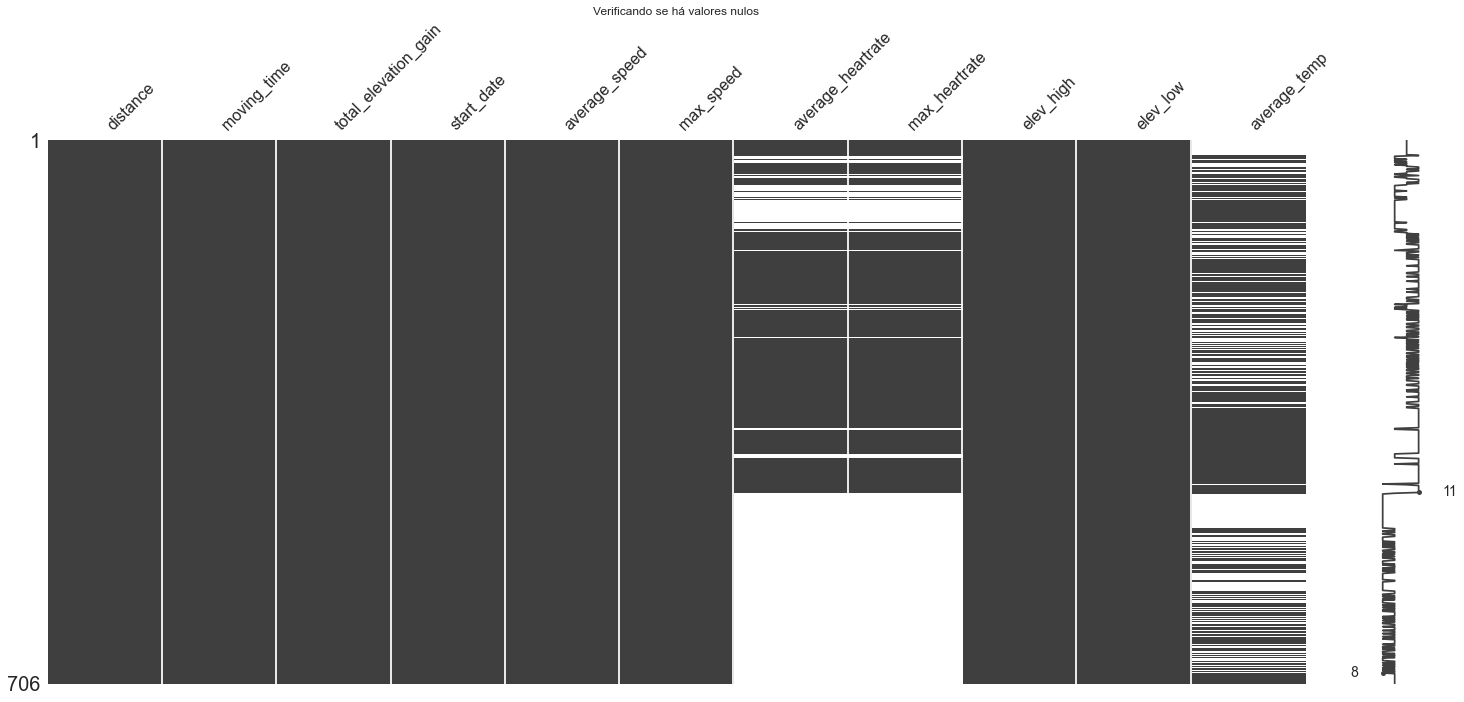

In [285]:
# exibindo visualização matricial da nulidade do dataset
ms.matrix(df_strava)
plt.title('Verificando se há valores nulos')

Tratando os valores nulos do dataset, neste ponto alguns atributos serão tratados considerando a mediana dos valores.

Text(0.5, 1.0, 'Visulizando se há valores nulos')

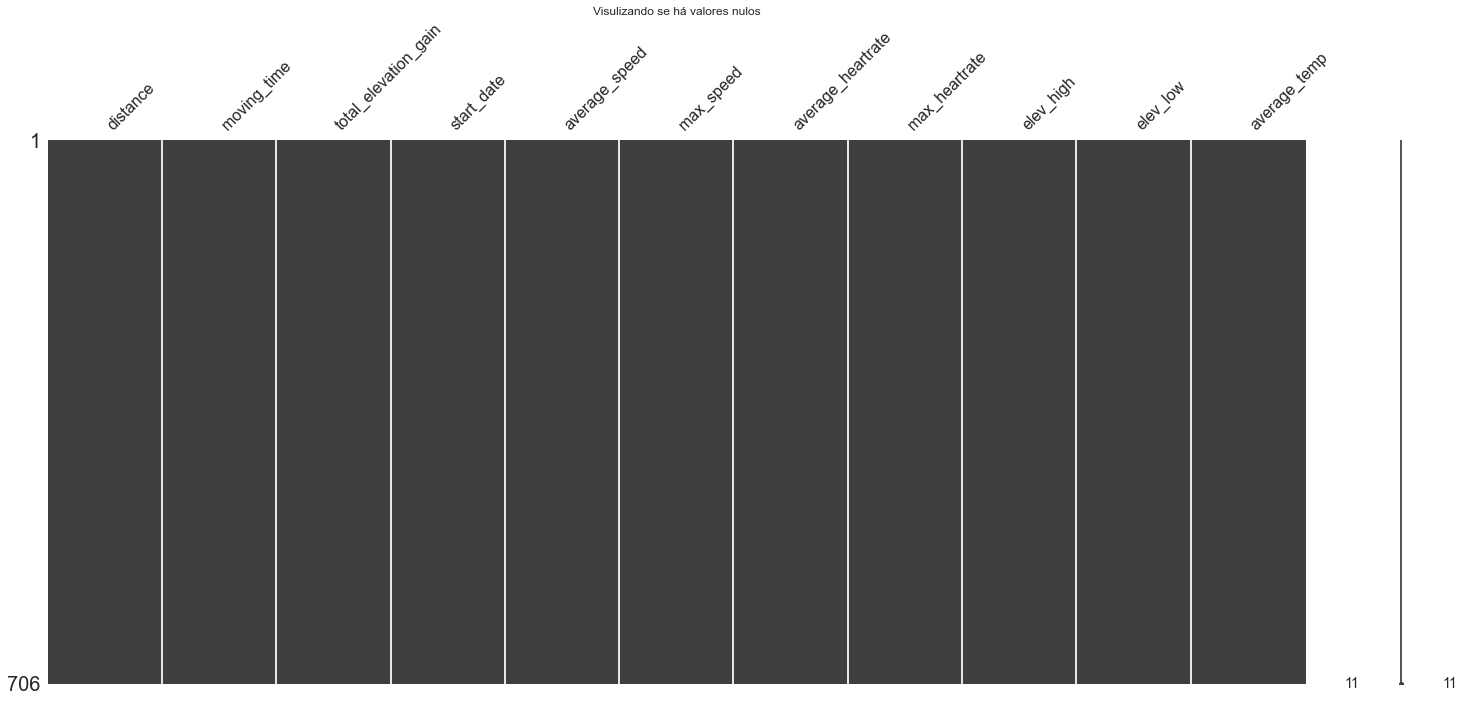

In [286]:
# substituindo os NaN de 'average_heartrate', 'max_heartrate' e 'average_temp' pela mediana da coluna
df_strava['average_heartrate'].fillna(df_strava['average_heartrate'].median(), inplace=True)
df_strava['max_heartrate'].fillna(df_strava['max_heartrate'].median(), inplace=True)
df_strava['average_temp'].fillna(df_strava['average_temp'].median(), inplace=True)

# visualizando se ha valores nulos
ms.matrix(df_strava)
plt.title('Visulizando se há valores nulos')

Neste ponto será criado o alvo (target) com base no atributo 'average_heartrate' (média de batimentos) para as análises seguintes.

In [287]:
df_lrstravatrain = df_strava.loc[:,['distance','moving_time','total_elevation_gain','average_speed','elev_high','max_speed', 'elev_low', 'average_temp']]

df_lrstravatrain['target'] = df_strava['average_heartrate']

df_lrstravatrain.head()


,distance,moving_time,total_elevation_gain,average_speed,elev_high,max_speed,elev_low,average_temp,target
1,21101.3,6345,546.2,3.326,598.3,11.460,274.3,26.0,143.3
2,59764.2,11776,779.3,5.075,575.1,14.545,277.4,26.0,148.3
3,35162.6,6060,616.3,5.802,506.1,12.472,277.1,26.0,147.9
4,19566.0,3826,367.3,5.114,520.1,12.807,273.8,26.0,152.0
6,19546.4,4244,373.9,4.606,525.2,12.215,275.0,26.0,147.8


Visualizando a correlação dos atributos.

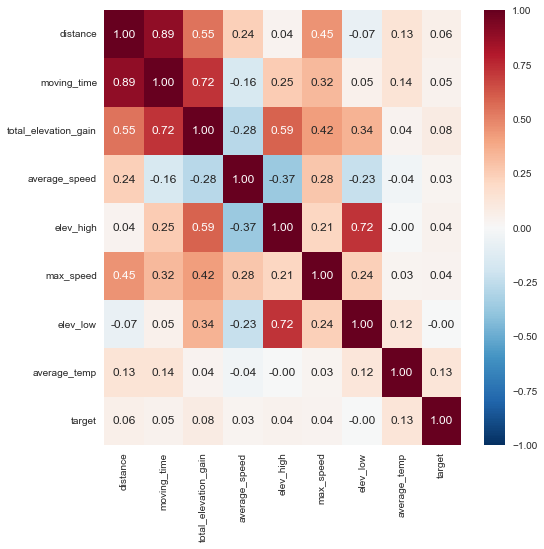

In [288]:
fig, ax = plt.subplots(figsize=(8,8))
ax = heatmap(
    df_lrstravatrain.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)

## 1.2 Modelagem
Nesta etapa será realizado uma exploração e preparação dos dados para verificar os modelos que atendam os requisitos de desempenho e precisão.

### 1.2.1 Separação da base
Apartir deste ponto a base é separada em bases de treino e testes

In [289]:
# Separação em bases de treino e teste (holdout)
array = df_lrstravatrain.values

lr_X = array[:,0:7] # atributos
lr_y = array[:,8] # classe (target)

lrX_train, lrX_test, lry_train, lry_test = train_test_split(lr_X, lr_y, test_size=0.3, random_state=42) # faz a divisão da base

# criando so folds
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

### 1.2.2. Avaliando os modelos
Realizando a comparação dos modelos para uma melhor escolha

LR: MSE -31.97 (12.69) - RMSE 5.65
Ridge: MSE -31.97 (12.69) - RMSE 5.65
Lasso: MSE -31.91 (12.70) - RMSE 5.65
KNN: MSE -39.29 (12.95) - RMSE 6.27
CART: MSE -70.91 (17.18) - RMSE 8.42
SVR: MSE -31.65 (12.58) - RMSE 5.63


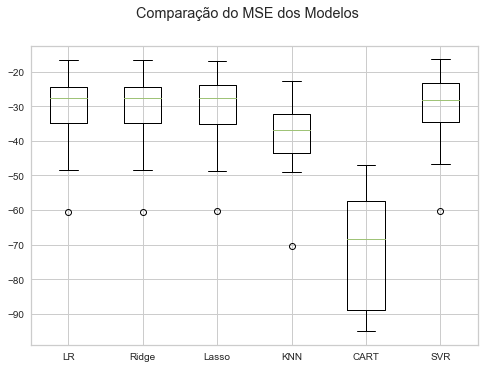

In [290]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7) 

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, lrX_train, lry_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2F" % (name, cv_results.mean(), cv_results.std(), np.sqrt(abs(cv_results.mean()))) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure() 
fig.suptitle('Comparação do MSE dos Modelos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

No gráfico acima é possível verificar que o modelos indicados são: Regressão Linear (LR), Ridge e Lasso.

### 1.2.3 Avalidando modelos com dados originais, padronizados e normalizados

LR-orig: -31.969 (12.685)
KNN-orig: -39.291 (12.947)
CART-orig: -68.816 (16.375)
SVR-orig: -31.651 (12.579)
LR-padr: -31.969 (12.685)
KNN-padr: -38.394 (14.589)
CART-padr: -70.808 (14.099)
SVR-padr: -31.626 (12.452)
LR-norm: -31.969 (12.685)
KNN-norm: -37.084 (13.642)
CART-norm: -65.001 (15.797)
SVR-norm: -31.600 (12.547)


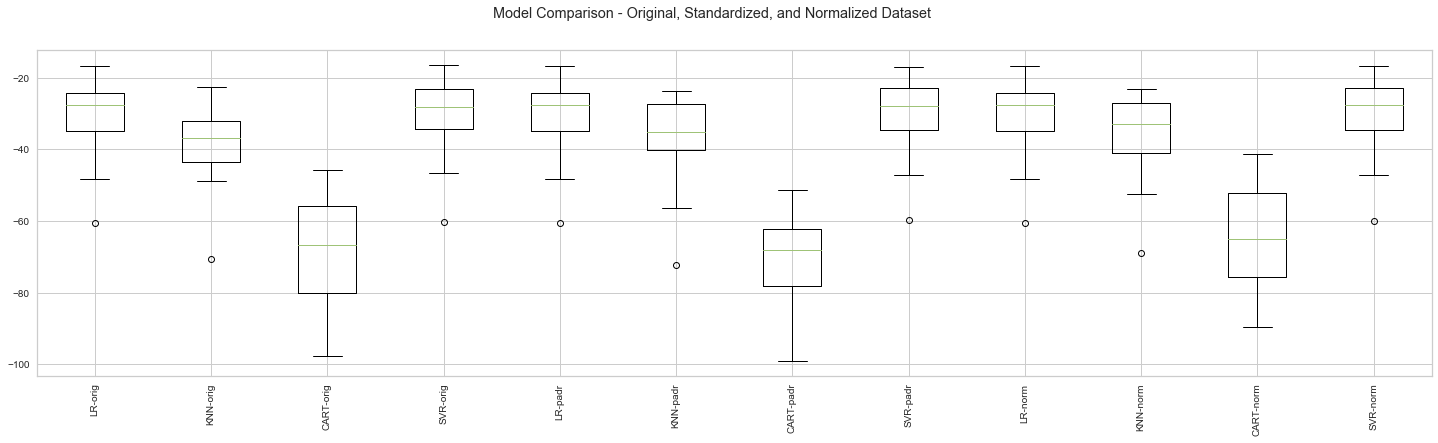

In [291]:
# Defining a global seed for this block
np.random.seed(7)

# Lists to store pipelines and results for all dataset views
pipelines = []
results = []
names = []

# Defining base classifier parameters for the BaggingClassifier
base_classifier = DecisionTreeRegressor()
num_trees = 100
max_features = 4

# Creating the pipeline elements

# Algorithms to be used
reg_log = ('LR', LinearRegression())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svr = ('SVR', SVR())
#random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))

# Transformations to be used
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Building the pipelines

# Original dataset
pipelines.append(('LR-orig', Pipeline([reg_log]))) 
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVR-orig', Pipeline([svr])))
#pipelines.append(('RF-orig', Pipeline([random_forest])))

# Standardized dataset
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log]))) 
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVR-padr', Pipeline([standard_scaler, svr])))
#pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))

# Normalized dataset
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVR-norm', Pipeline([min_max_scaler, svr])))
#pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))

# Executing the pipelines
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
scoring = 'neg_mean_squared_error'

for name, model in pipelines:
    cv_results = cross_val_score(model, lrX_train, lry_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatting to 3 decimal places
    print(msg)

# Boxplot comparing the models
fig = plt.figure(figsize=(25,6))
fig.suptitle('Model Comparison - Original, Standardized, and Normalized Dataset') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

No gráfico acima observa-se que o modelo SVR padronizado (SVR-padr) tem uma tendência melhor de resultado - SVR-padr: -31.626 (12.452).

## 1.3 Análise Modelos
Neste ponto será criado os modelos e analisado os scores e os coeficientes de cada modelo.


Para essa análise os dados serão padronizados seguindo orientação com base no gráfico acima.

In [292]:
# Padronizando os dados
lr_sX = preprocessing.StandardScaler().fit_transform(lr_X)

# separando os dados
sX_train, sX_test, sy_train, sy_test = model_selection.train_test_split(lr_sX, lr_y, test_size=0.3, random_state=42)

#### 1.3.1 Regressão Linear

Criando o modelo de regressão linear com os dados pradronizados

In [293]:
lr = LinearRegression()
lr.fit(sX_train, sy_train)

LinearRegression()

In [294]:
saidat = lr.intercept_\

print(saidat)

151.88846484318407


Visualizando o score do modelo criado

In [295]:
lr.score(sX_test, sy_test)

0.011014725449899787

O score de 0.01 sugere que o modelo de regressão linear não está adequado para descrever a relação entre os recursos e a variável de resposta nos dados fornecidos.

Visualizando o coeficiente

In [296]:
lr.coef_

array([ 0.30568327, -0.50296938,  0.75835838,  0.4555332 ,  0.2395872 ,
       -0.29488616, -0.18351162])

Gerando gráfico para ver a importância dos atributos na regressão linear.

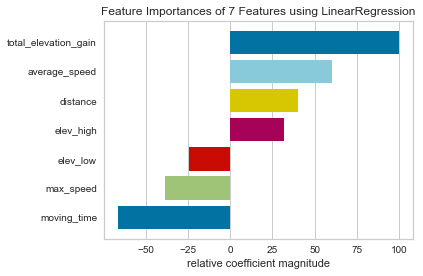

<AxesSubplot:title={'center':'Feature Importances of 7 Features using LinearRegression'}, xlabel='relative coefficient magnitude'>

In [297]:
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(lr, labels=df_lrstravatrain.columns)
fi_viz.fit(lr_X, lr_y)
fi_viz.poof()

Observa-se que o atributo total_elevation_gain aumenta o target, enquanto moving_time reduz o valor.

Na tentativa de identificar o melhor padrão dos dados, abaixo removi os atributos moving_time, max_speed e elev_low para uma nova análise do modelo de Regressão Linear.

In [298]:
df2_lrstravatrain = df_lrstravatrain.loc[:,['distance','total_elevation_gain','average_speed','elev_high','average_temp','target']]

array2 = df2_lrstravatrain.values
df2_X = array2[:,0:4]
df2_y = array2[:,5]

# Padronizando os dados
lr2_sX = preprocessing.StandardScaler().fit_transform(df2_X)

# separando os dados
sX2_train, sX2_test, sy2_train, sy2_test = model_selection.train_test_split(lr2_sX, df2_y, test_size=0.3, random_state=42)

# criando so folds
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

lr2 = LinearRegression()
lr2.fit(sX2_train, sy2_train)
lr2.score(sX2_test, sy2_test)


0.00796777875620669

Mesmo com um novo conjunto de dados não obtive um resultado para considerar aceitável o modelo.

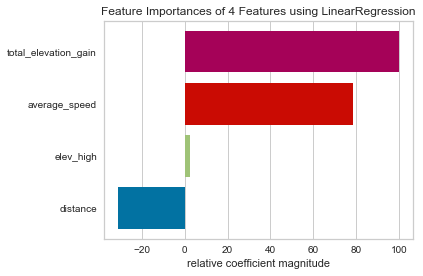

<AxesSubplot:title={'center':'Feature Importances of 4 Features using LinearRegression'}, xlabel='relative coefficient magnitude'>

In [299]:
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(lr2, labels=df2_lrstravatrain.columns)
fi_viz.fit(df2_X, df2_y)
fi_viz.poof()

### 1.3.2 SVMs

As SVMs fazem regressão com eficiência na execução e será analisado para uma melhor definição do modelo ideal.

In [300]:
svr = SVR()
svr.fit(sX_train, sy_train)

SVR()

In [301]:
svr.score(sX_test, sy_test)

0.01122057633626905

Aqui observar-se que o score do SVR apresenta um resultado somente de 1,1% de variabilidade dos dados indicando que não esta fazendo boa previsão.

### 1.3.3 K vizinhos mais próximos
Este modelo calcula a média dos alvos para determinar uma predição.

In [302]:
knr = KNeighborsRegressor()
knr.fit(sX_train, sy_train)

KNeighborsRegressor()

In [303]:
knr.score(sX_test, sy_test)

-0.024444479791588813

Pelo modelo apresentar um score negativo demonstra baixa qualidade nos dados e seus atributos, mostrando que o Knr também apresenta baixa resultado para a análise.

### 1.3.4 Árvore de decisão
O modelo de árvore de decisão avalia a separação dos atributos em cada nível da árvore.

In [304]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(sX_train, sy_train)

DecisionTreeRegressor(random_state=42)

In [305]:
dtr.score(sX_test, sy_test)

-0.9749595484932745

É possivel observar que o resultado (score) mostra que o modelo não esta bom para análise.

Visualizando a Árvore de Decisão

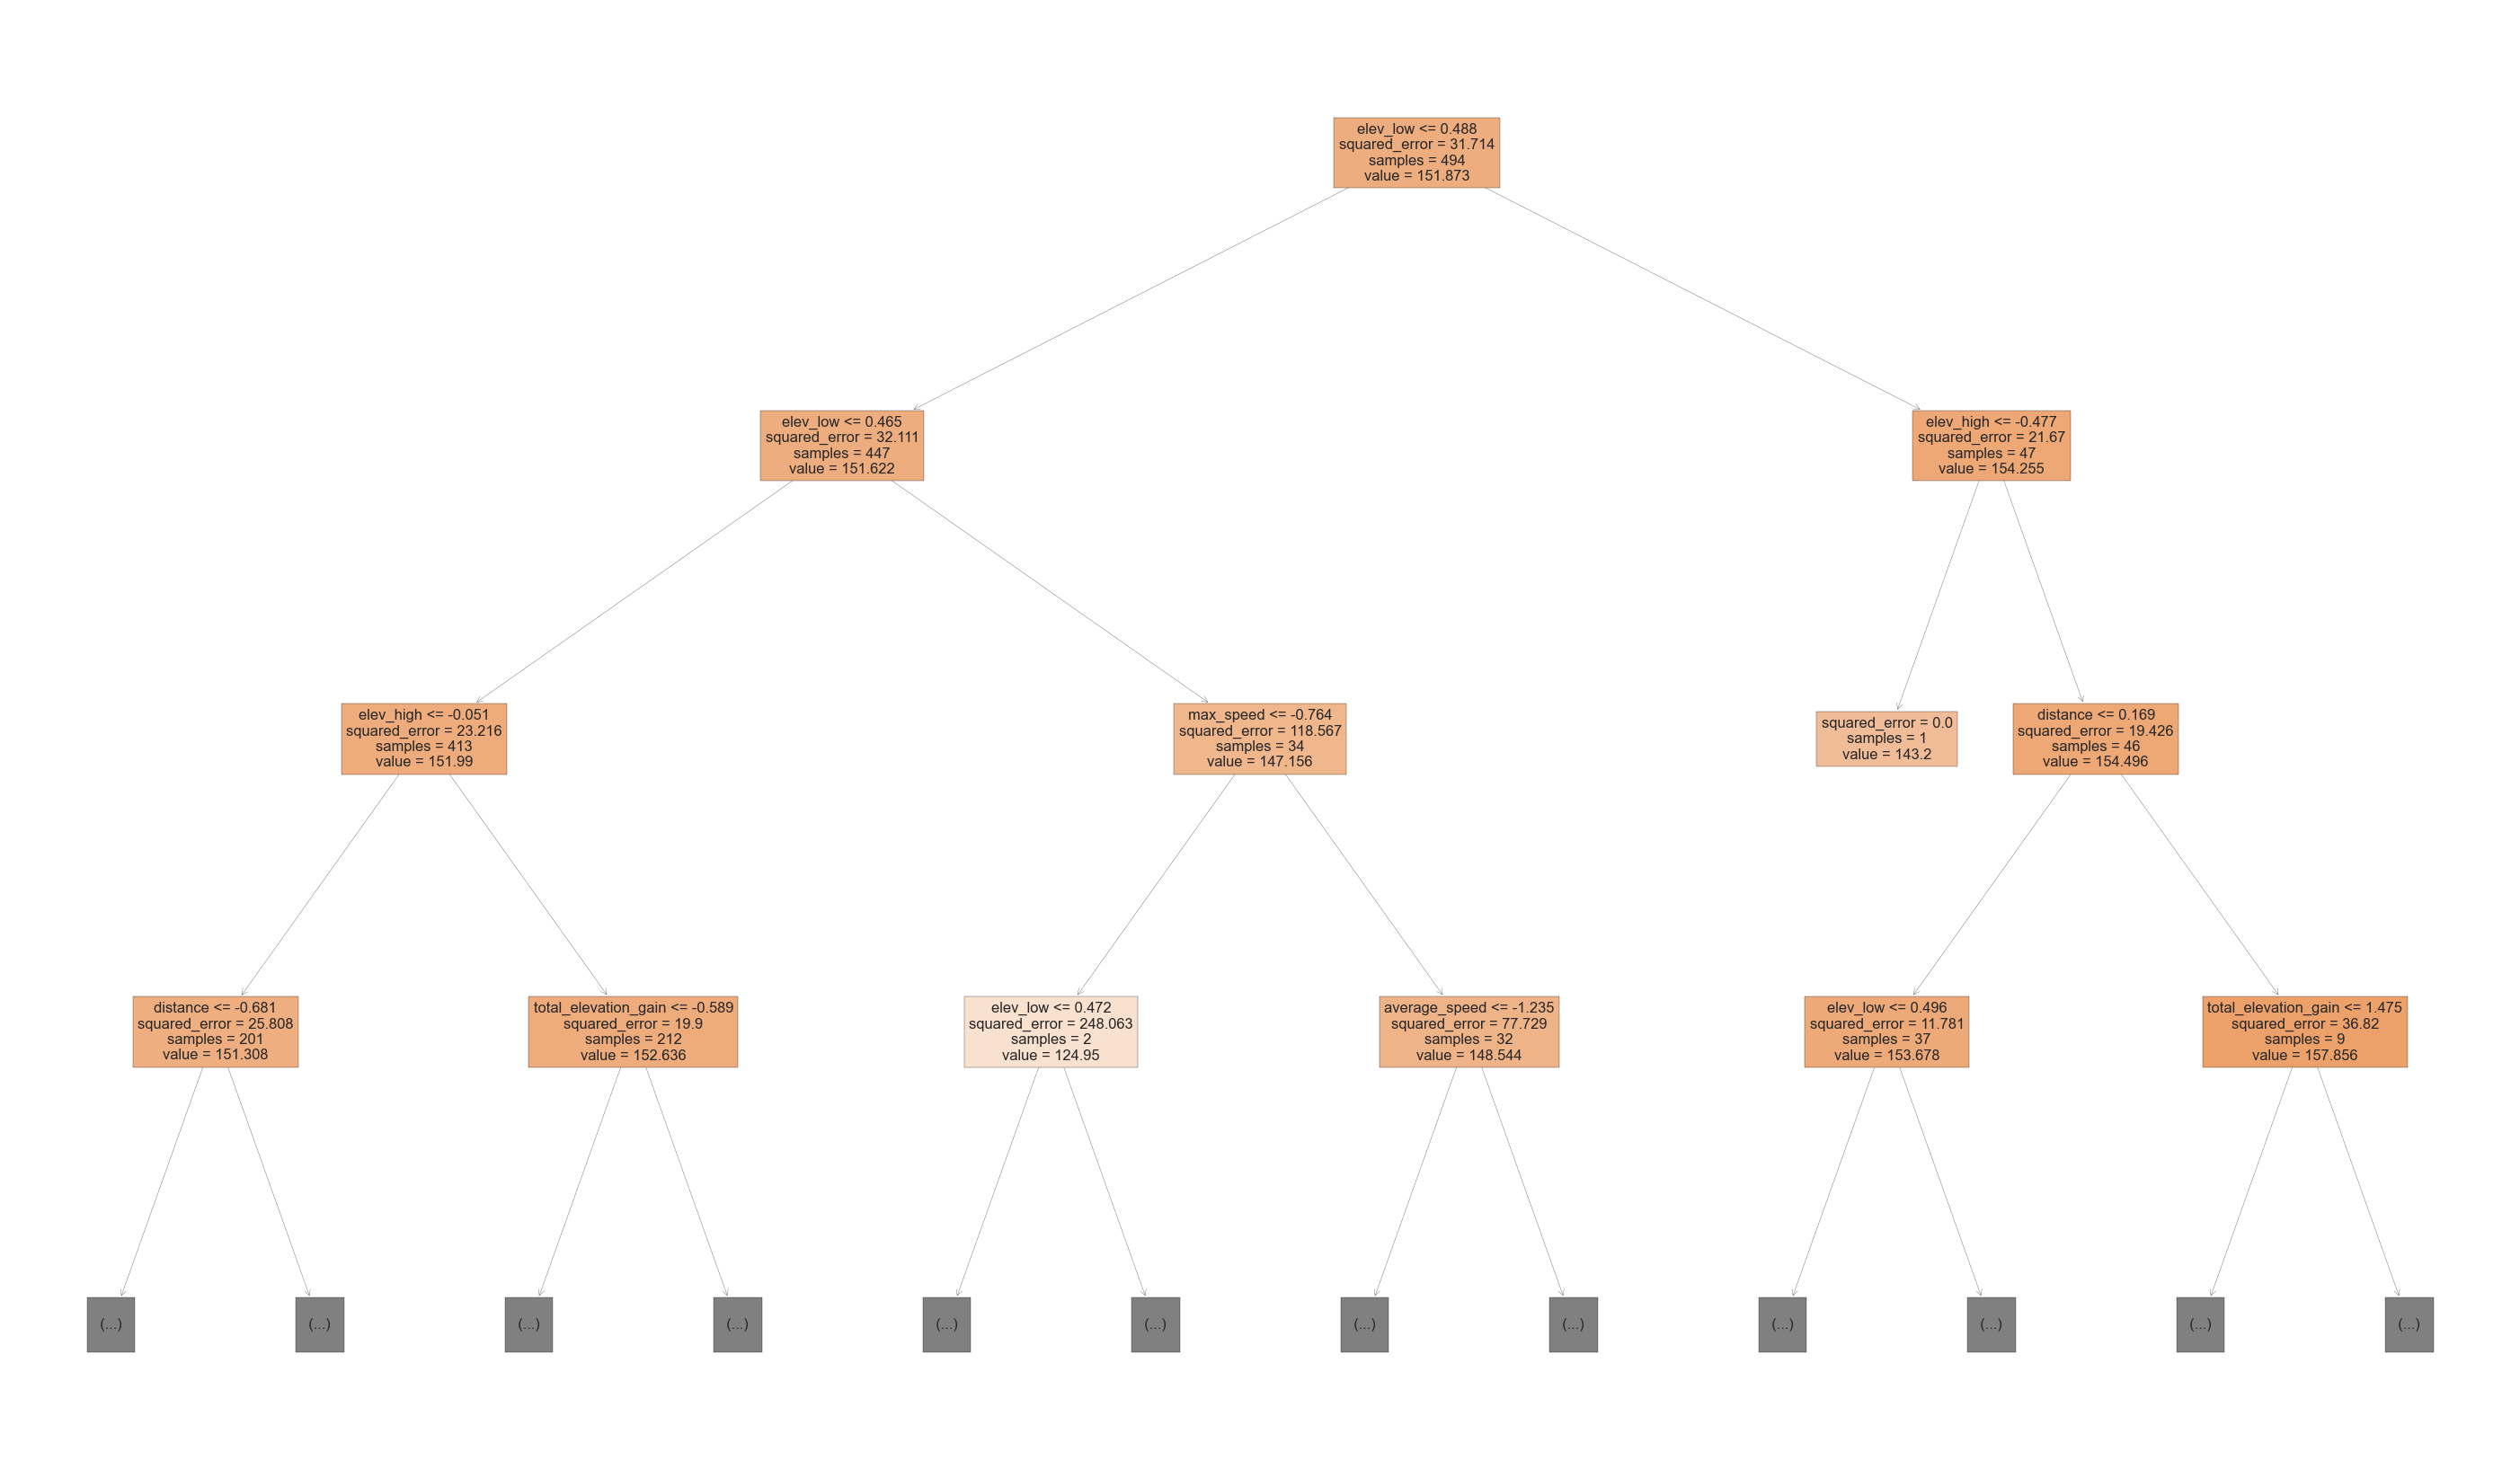

In [306]:
# Plot the CART model
plt.figure(figsize=(50, 30))
plot_tree(dtr, max_depth=3, filled=True, feature_names=df_lrstravatrain.columns, class_names=[str(x) for x in df_lrstravatrain['target'].unique()]) #df_lrstravatrain['target'].astype(str))
plt.show()

Melhor visualização da Árvore de Decisão

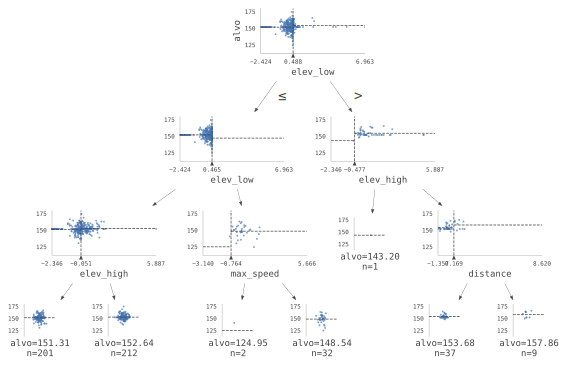

In [307]:
# Arvore de decisao em regressao
dtr3 = DecisionTreeRegressor(max_depth=3)
dtr3.fit(sX_train, sy_train)
viz = dtreeviz.model(
    dtr3,
    sX_train,
    sy_train,
    target_name="alvo",
    feature_names=df_lrstravatrain.columns,
    )
viz.view(fontname="monospace")

Verificando a importância dos atributos na árvore de decisão é possível verificar uma diferença em coparação com o modelo de regressão linear acima.
No gráfico acima é possível observar que há uma tendência para os valores de saída o que não poder ser um bom resultado final.

In [308]:
# importancia dos atributos

for col, val in sorted(
    zip(
        df_lrstravatrain.columns, dtr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

elev_low       0.193
elev_high      0.182
average_speed     0.173
max_speed      0.169
distance       0.112


### 1.3.5 Floresta Aleatória
A floresta aleatória tem uma tendência melhor de generalização.

In [309]:
# floresta aleatória

rfr = RandomForestRegressor(
    random_state=42, n_estimators=90
)
rfr.fit(sX_train, sy_train)

RandomForestRegressor(n_estimators=90, random_state=42)

In [310]:
rfr.score(sX_test, sy_test)

-0.017846963849486253

Assim como os modelos acima o modelo floresta aleatória também não apresenta boa variabilidade nos dados de testes.

Listando a importância dos atributos na árvore de decisão é possível observar pequena variação entre eles.

In [311]:
# importancia dos atritubos da árvore
for col, val in sorted(
    zip(
        df_lrstravatrain.columns, rfr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

elev_low       0.199
elev_high      0.174
max_speed      0.148
average_speed     0.140
total_elevation_gain     0.136


### 1.3.6 Regressão XGBosst
A biblioteca XGBoost constroí uma árvore de decisão simples e faz melhorias adicionando árvores subsequentes.

In [312]:
xgr = xgb.XGBRegressor(random_state=42)
xgr.fit(sX_train, sy_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [313]:
xgr.score(sX_test, sy_test)

-0.04845719737757448

Quando você obtém um 𝑅2 negativo, isso geralmente sugere que o modelo ajustado está muito mal adaptado aos dados ou que há problemas significativos com o ajuste do modelo. Isso pode ser devido a vários fatores, como:

* Falta de relação linear entre os recursos e a variável dependente.
* Overfitting do modelo aos dados de treinamento.
* Viés significativo nos dados de treinamento.

In [314]:
xgr.predict(lr_X[[0]])

array([154.05524], dtype=float32)

Visualizando a importância dos atributos

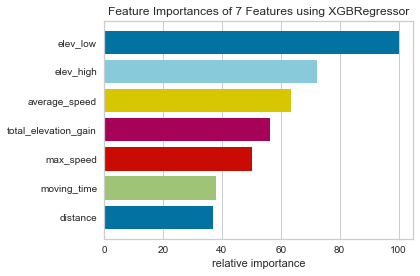

<AxesSubplot:title={'center':'Feature Importances of 7 Features using XGBRegressor'}, xlabel='relative importance'>

In [315]:
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(xgr, labels=df_lrstravatrain.columns)
fi_viz.fit(sX_train, sy_train)
fi_viz.poof()

Visualizando a árvore de decisão XGBoost

<AxesSubplot:>

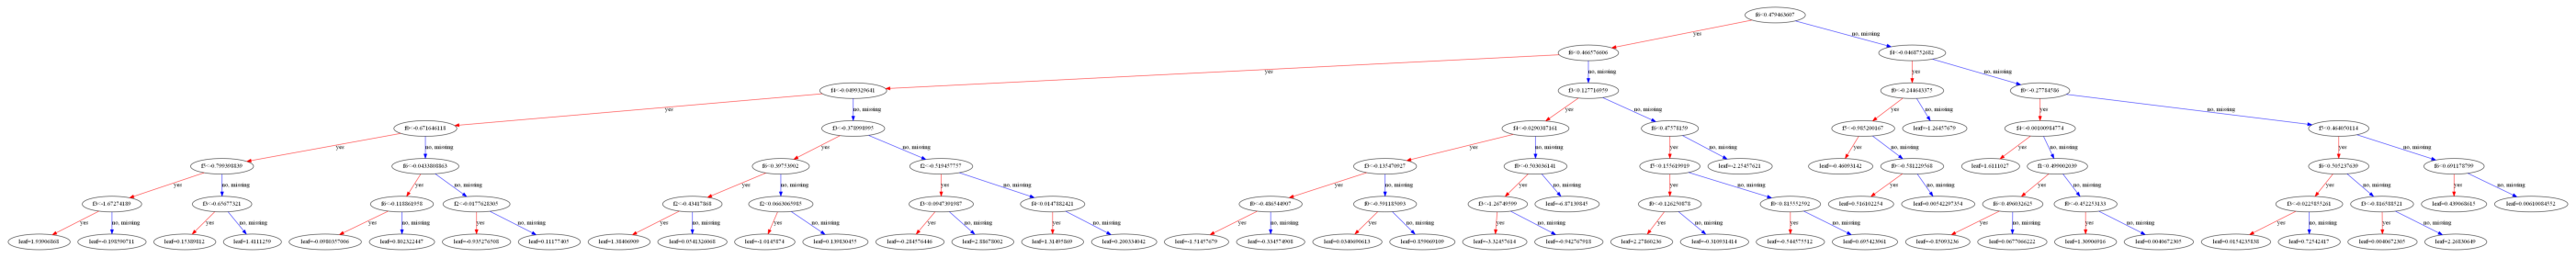

In [316]:
fig, ax = plt.subplots(figsize=(50,20))
xgb.plot_tree(xgr, ax=ax, num_trees=0)

### 1.3.7 Lasso
Lasso (Least Absolute Shrinkage and Selection Operator) faz regressão linear com regularização

In [317]:
# Treinar o modelo Lasso
lasso_model = Lasso(alpha=0.1)  # Escolha do valor de alpha
lasso_model.fit(sX_train, sy_train)

Lasso(alpha=0.1)

In [318]:
lasso_model.score(sX_test, sy_test)

0.009293678949694795

Este modelo também náo tem boa resposta para a variabilidade dos dados.

## 1.4 Métricas e avaliação de regressao
Neste ponto será avalidado o resultado do modelo de regressão de floresta aleatória 

In [319]:
rfr.score(sX_test, sy_test)

-0.017846963849486253

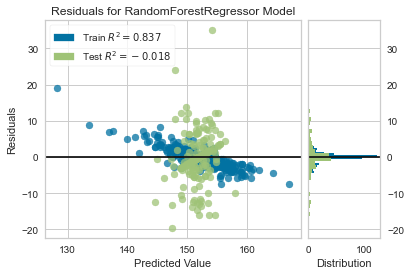

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [320]:
# grafico de resíduos
fig, ax = plt.subplots(figsize=(6,4))

rpv = ResidualsPlot(rfr)
rpv.fit(sX_train, sy_train)
rpv.score(sX_test, sy_test)
rpv.poof()


No gráfico acima é possível observar a discrepancia dos valores e o impacto na adequação do modelo.

A biblioteca scipy inclui um gráfico de probabiliddes e o teste de Kolmagorov-Smirnov que verificam se os resíduos tem distribuição normal.

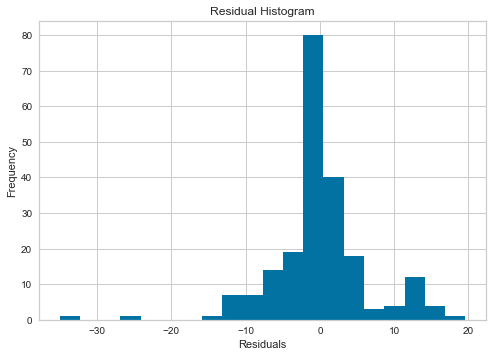

In [321]:
import statsmodels.stats.api as sms
resids = lry_test - rfr.predict(sX_test)
plt.hist(resids, bins=20)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

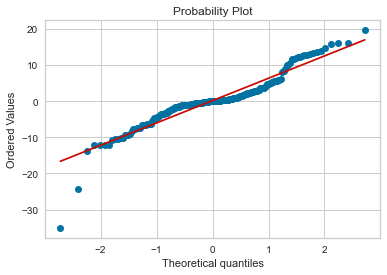

In [322]:

fig, ax = plt.subplots(figsize=(6,4))
_ = stats.probplot(resids, plot=ax)

In [323]:
stats.kstest(resids, cdf="norm")

KstestResult(statistic=0.26289080416553345, pvalue=2.03189122569539e-13, statistic_location=2.051111111111169, statistic_sign=-1)

Com os gráficos acima é possível observar que não há um alinhamento na distribuição.
Abaixo visualiza-se o gráfico de erros de predição que mostra que os alvos e os previstos não estão alinhados.

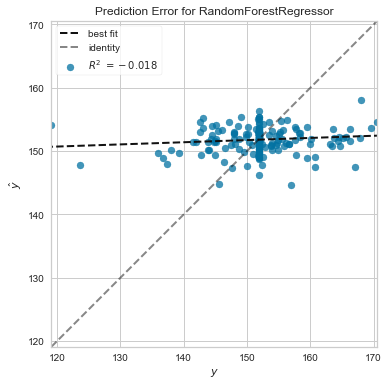

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [324]:
fig, ax = plt.subplots(figsize=(6,6))
pev = PredictionError(rfr)
pev.fit(sX_train, sy_train)
pev.score(sX_test, sy_test)
pev.poof()

## 1.5 Explicando algums modelos

Usando a biblioteca SHAP para interpretar o modelo XGBoost construído acima.

In [325]:
sample_idx = 10
xgr.predict(lr_X[[sample_idx]])

array([154.05524], dtype=float32)

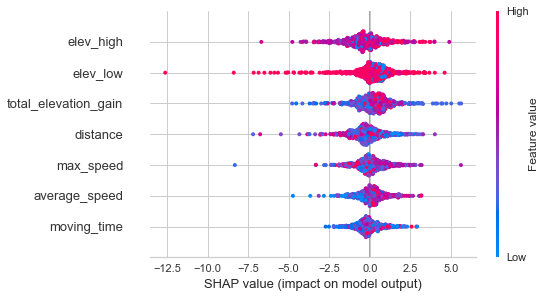

In [326]:
exp = shap.TreeExplainer(xgr)
vals = exp.shap_values(lr_sX)
fig, ax = plt.subplots(figsize=(6,4))
shap.summary_plot(vals, lr_X,feature_names=df_lrstravatrain.columns)


Neste gráfico é possível observar o impacto da variável elev_low no modelo e ver que empurram o valor do target para baixo.

## 1.6 PCA
Redução da dimensionalidade

In [327]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(lr_sX)
)
pca.explained_variance_ratio_


array([0.43211526, 0.27195343, 0.16127734, 0.0646378 , 0.04182263,
       0.02428274, 0.0039108 ])

No gráfico abaixo é usado o método do cotovelo (elbow method) para ver se ele se curva a fim de determinar quantoso pontos componentes devem ser usados.

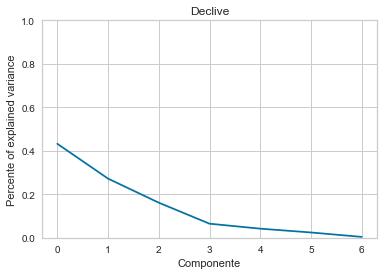

In [328]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pca.explained_variance_ratio_)
ax.set(
    xlabel="Componente",
    ylabel = "Percente of explained variance",
    title="Declive",
    ylim=(0,1),
)
plt.show()

Usando a função imshow da matplotlib para gerar um gráfico com os componentes e os atributos origininais onde a maior cor escura será a contribuição da coluna original ao componente.

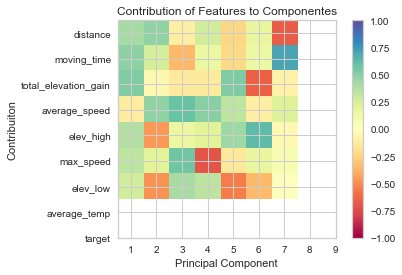

In [329]:
fig, ax = plt.subplots(figsize=(6,4))
plt.imshow(
    pca.components_.T,
    cmap="Spectral",
    vmin=-1,
    vmax=1,
)
plt.yticks(range(len(df_lrstravatrain.columns)), df_lrstravatrain.columns)
plt.xticks(range(9), range(1,10))
plt.xlabel("Principal Component")
plt.ylabel("Contribuiton")
plt.title(
    "Contribution of Features to Componentes"
)
plt.colorbar()

Testando a redução da dimensionalidade com PCA (Principal Component Analysis)

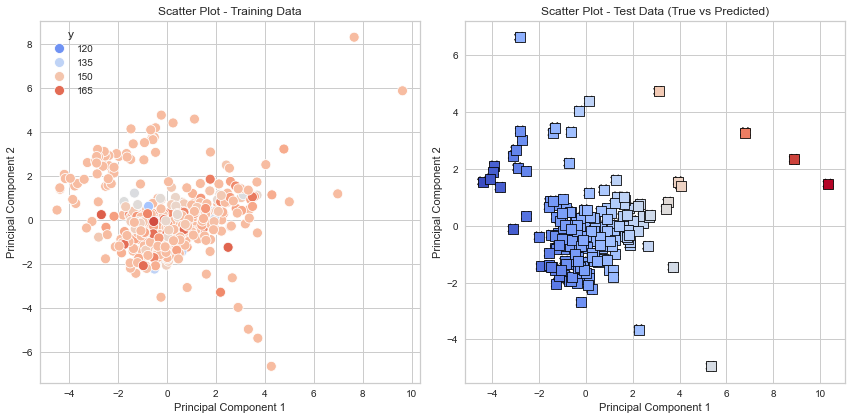

In [330]:
# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(sX_train)
X_test_scaled = scaler.transform(sX_test)

# Reduzir a dimensionalidade dos dados usando PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Treinar o modelo de regressão linear nos dados reduzidos
model = LinearRegression()
model.fit(X_train_pca, sy_train)

# Fazer previsões
y_pred = model.predict(X_test_pca)

# Criar um DataFrame para os dados de treino
df_train = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_train['y'] = sy_train

# Criar um DataFrame para os dados de teste
df_test = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
df_test['y_true'] = sy_test
df_test['y_pred'] = y_pred

# Plotar o gráfico de dispersão com Seaborn
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_train, x='PC1', y='PC2', hue='y', palette='coolwarm', legend='brief', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot - Training Data')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_test, x='PC1', y='PC2', hue='y_true', palette='coolwarm', legend=False, s=100, marker='X', edgecolor='black')
sns.scatterplot(data=df_test, x='PC1', y='PC2', hue='y_pred', palette='coolwarm', legend=False, s=100, marker='s', edgecolor='black')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot - Test Data (True vs Predicted)')

plt.tight_layout()
plt.show()

## 1.7 Otimização Hiperparâmetros
Utilizando o gridsearch para ajuste de hiperparâmetros

In [331]:
# Definir a grade de hiperparâmetros a serem testados
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [True, False],
    'positive': [True, False]
}

# Inicializar a busca em grade
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Executar a busca em grade nos dados de treinamento
grid_search.fit(sX_train, sy_train)

# Obter o melhor modelo e os melhores parâmetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

#print("Melhores Parâmetros:", best_params)

# Avaliar o melhor modelo encontrado
best_model = grid_search.best_estimator_
print("Melhores Hiperparâmetros Encontrados:", grid_search.best_params_)

# Fazer previsões com o melhor modelo
y_pred = best_model.predict(sX_test)

# Calcular o erro quadrático médio (MSE) das previsões
mse = mean_squared_error(sy_test, y_pred)
print("Mean Squared Error (MSE) do Melhor Modelo:", mse)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores Hiperparâmetros Encontrados: {'copy_X': True, 'fit_intercept': True, 'n_jobs': True, 'positive': True}
Mean Squared Error (MSE) do Melhor Modelo: 40.495936396550036


In [332]:
# Definindo os modelos e seus hiperparâmetros
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'param_grid': {'fit_intercept': [True, False]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'param_grid': {'n_estimators': [50, 100, 200]}
    },
    'Support Vector Machine': {
        'model': SVR(),
        'param_grid': {'kernel': ['linear', 'rbf'], 'C': [1, 10, 100]}
    }
}

# Realizando a busca em grade para cada modelo
for model_name, model_params in models.items():
    print(f"Testing {model_name}...")
    grid_search = GridSearchCV(model_params['model'], model_params['param_grid'], cv=5)
    grid_search.fit(sX_train, sy_train)
    print("Best parameters found:")
    print(grid_search.best_params_)
    print("Best score:")
    print(grid_search.best_score_)
    print()

Testing Linear Regression...
Best parameters found:
{'fit_intercept': True}
Best score:
-0.0333378255623745

Testing Random Forest...
Best parameters found:
{'n_estimators': 100}
Best score:
-0.13920683571625864

Testing Support Vector Machine...
Best parameters found:
{'C': 1, 'kernel': 'rbf'}
Best score:
-0.009172397620078598



Neste ponto é possível verificar que mesmo com a otimização o resultado não é satisfatório.

# 2 Avaliação dos Modelos

Neste ponto será feito uma avaliação de alguns modelos treinados acima com dados não vistos com o objetivo de se visualizar alguma tendência nos resultados.

In [333]:
# selecionando os dados da base de entrada 


df_entrada = df.loc[:,['distance','moving_time','total_elevation_gain','average_speed','max_speed','elev_high', 'elev_low','average_temp']]

df_entrada = df_entrada.dropna()

df_entrada.head()

,distance,moving_time,total_elevation_gain,average_speed,max_speed,elev_high,elev_low,average_temp
61,25468.3,5487,317.0,4.642,13.052,405.2,227.8,29.0
62,18394.9,5827,561.0,3.157,9.772,473.4,205.2,28.0
63,21962.0,5366,563.0,4.093,12.454,470.4,189.4,21.0
64,32064.5,8182,564.0,3.919,11.872,505.0,258.0,24.0
65,17992.0,6091,514.0,2.954,10.422,538.6,211.8,27.0


### 2.1 XGBoost

Separando os dados não vistos para avaliação do modelo XGBBoost.

In [334]:
array_entrada = df_entrada.values
X_entrada = array_entrada[:,0:7]

# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(lrX_train) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(lrX_train) # aplicação da padronização com TODO o dataset
xgr.fit(rescaledX, lry_train)

#Padronizada dados entrada
rescaladeEntradaX = scaler.transform(X_entrada)
print(rescaladeEntradaX)

[[-5.58045339e-01 -4.09723198e-01 -7.36599964e-01 ... -2.24476087e+00
   1.44499831e+02  1.85679162e-02]
 [-9.24840731e-01 -3.07268303e-01  2.02337615e-02 ... -2.26144731e+00
   1.69677388e+02 -1.86132038e-01]
 [-7.39866625e-01 -4.46185086e-01  2.64373167e-02 ... -2.24780309e+00
   1.68569870e+02 -3.29240856e-01]
 ...
 [ 2.22888196e+00  2.03352469e+00 -1.47792480e+00 ... -2.26181360e+00
   1.55628503e+00 -2.11719533e+00]
 [ 5.93185254e-01  3.17405214e-01 -1.54616391e+00 ... -2.25723500e+00
  -4.94114888e+00 -2.15885992e+00]
 [-4.18927138e-01  1.18103970e+00  1.60834387e+00 ... -2.27198826e+00
   2.86852701e+02  5.69265140e-01]]


Agora é feita a predição dos dados não vistos com o modelo XGBoost - XGRRegressor()

In [335]:
# fazendo a predicao
saidas  = xgr.predict(rescaladeEntradaX)

Comprando os valores não vistos com o previsto.

Mean Squared Error (MSE): 55.03649992484383
R-squared (R2): -0.34558770441209785


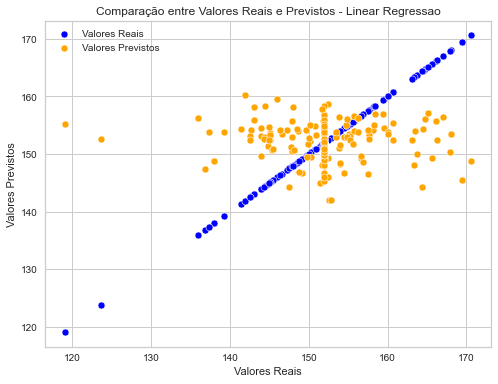

In [336]:
min_length = min(len(lry_test), len(saidas))
y_test = lry_test[:min_length]
y_pred = saidas[:min_length]

# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Valores Reais')
sns.scatterplot(x=y_test, y=y_pred, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos - Linear Regressao")
plt.show()

No gráfico acima é possível observar que os valores reais utilizados para o treino não se alinham com os valores do modelo de dados não visto.

## 2.2 Lasso

Realizando a predição do modelo Lasso com dados não visto e visualizando a relação entre eles.

In [337]:
# Fazer previsões
lasso_pred = lasso_model.predict(rescaladeEntradaX)

min3_length = min(len(lry_test), len(lasso_pred))
y3_test = lry_test[:min3_length]
y3_pred = lasso_pred[:min3_length]

# Calcular métricas de desempenho
mse3 = mean_squared_error(y3_test, y3_test)
r23 = r2_score(y3_test, y3_pred)

print("Mean Squared Error (MSE):", mse3)
print("R-squared (R2):", r23)

Mean Squared Error (MSE): 0.0
R-squared (R2): -0.0012741805059151012


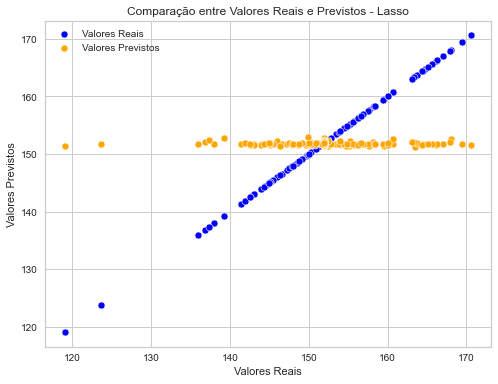

In [338]:
# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=y3_test, y=y3_test, color='blue', label='Valores Reais')
sns.scatterplot(x=y3_test, y=y3_pred, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos - Lasso")
plt.show()

No gráfico acima é possível observar que o modelo não esta alinhado e que há uma indicação de overfitting .

# 3 Conclusão

Conclui-se que o modelo não apresenta boas características para a análise de Regressão, mesmo com testes de remoção e inserção de atributos não foi suficiente para obter um resultado satisfatório para aplicação em um ambiente real. Acredita-se que pode ter ocorrido vazamento de dados (data leakage), mostrando-se necessário uma análise mais aprofundada para um melhor entendimento das informações, mas é possível observar que se realizado novos ajustes e talvez inserido novos dados o modelo consiga ser treinado para realizar previsões mais precisas.

Usando o processo de PolynomialFeatures que consiste em transformar as características originais em todas as combinações possíveis de potências e interações polinomiais até um determinado grau especificado podemos observar que o modelo também não apresenta boa dimensionalidade.

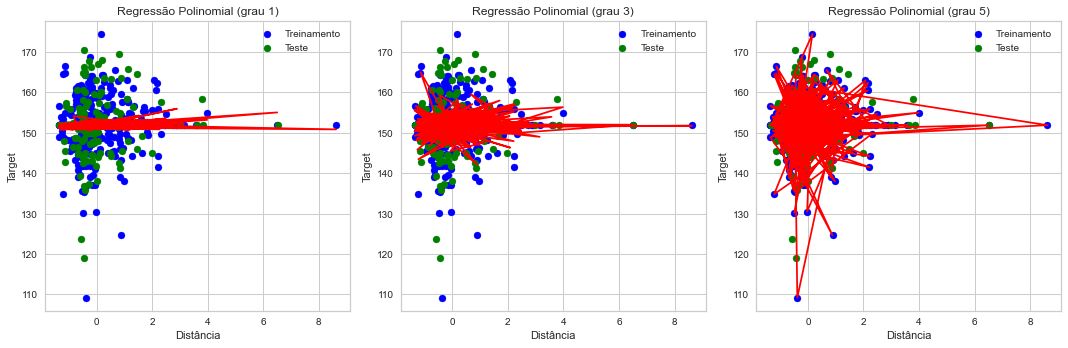

In [339]:
# Definir graus polinomiais para modelos de diferentes complexidades
degrees = [1, 3, 5]

# Calcular o erro de treinamento e teste para cada grau polinomial
train_errors = []
test_errors = []

plt.figure(figsize=(15, 5))

for i, degree in enumerate(degrees, 1):
    # Criar pipeline com polinômio e regressão linear
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("linear", LinearRegression())
    ])
    model.fit(sX_train, sy_train)
    
    # Prever nos conjuntos de treinamento e teste
    sy_train_pred = model.predict(sX_train)
    sy_test_pred = model.predict(sX_test)
    
    # Calcular erro médio quadrático nos conjuntos de treinamento e teste
    train_error = mean_squared_error(sy_train, sy_train_pred)
    test_error = mean_squared_error(sy_test, sy_test_pred)
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    # Plotar gráficos
    plt.subplot(1, len(degrees), i)
    plt.scatter(sX_train[:, 0], sy_train, color='blue', label='Treinamento')
    plt.scatter(sX_test[:, 0], sy_test, color='green', label='Teste')
    plt.plot(sX_train[:, 0], sy_train_pred, color='red')
    plt.xlabel('Distância')
    plt.ylabel('Target')
    plt.title(f'Regressão Polinomial (grau {degree})')
    plt.legend()

plt.tight_layout()
plt.show()